<a href="https://colab.research.google.com/github/hashaam13/Computer-vision/blob/main/ImageProc_Lecture5_en_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Notebook we will discuss the 2D discrete wavelet transform (DWT) and how to use it for image compression. 
First of all, install the required library version and connect all the becessary packets.


In [ ]:
!pip install opencv-python==4.4.0.42
!pip install PyWavelets

In [ ]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
import pywt
import pywt.data
import numpy as np
from math import sqrt
from PIL import Image, ImageChops, ImageOps
import pickle

**2D discrete wavelet transform (DWT) in Python** 

Wavelet transforms are based on the fact that neighbouring pixels almost do not differ from each other in real images. If instead of the values of two neighboring pixels we take their half-sum and half-difference, then we obtain two filtered images as a result, and it is easy to restore the original one using them. By averaging the intensity (that is, taking the half-sum), we apply a certain frequency filter. On the other hand, taking half-differences, "highlights" inter-pixel bursts among the values ​​and eliminates the constant component, thus, being in a sense an equivalent to using a low-pass filter.

The Haar wavelet transform is a pair of filters that split a signal into low-frequency and high-frequency components. The Daubechies wavelet transform takes four values, each with an offset of 2. Exactly these two transformations we are going to consider below.

Let's start by implementing discrete wavelet transform using Python. First, let's read a black-and-white image and display it on the screen. If the original image turns out to be colored, then you have to work with each of its channels separately.


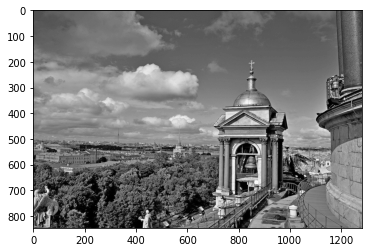

In [ ]:
img = cv2.imread('peter.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(image,cmap='gray');

Let's make the Haar wavelet transform using dwt2 function, taking in the original image and wavelet name (in our case "haar") as arguments.

In [ ]:
wavelet = 'haar'
c = pywt.dwt2(image,wavelet)
cA, (cH, cV, cD)= c


As a result of this function implementation, we obtain 4 sets (filters) (cA, (cH, cV, cD)) (one average and 3 detailed - horizontal, vertical and diagonal). In the discrete case, filters are specified simply by listing their values ​​(coefficients) at sampling points.

                            -------------------
                            |        |        |   L - low
                            | cA(LL) | cH(LH) |   H - high
                            |        |        |
                            -------------------
                            |        |        |
                            | cV(HL) | cD(HH) |
                            |        |        |
                            -------------------


Let's display the images corresponding to each set


0


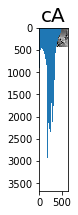

1


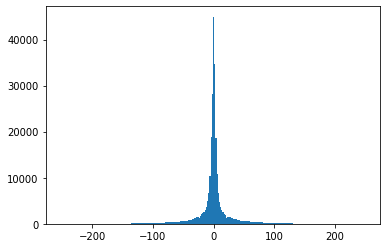

2


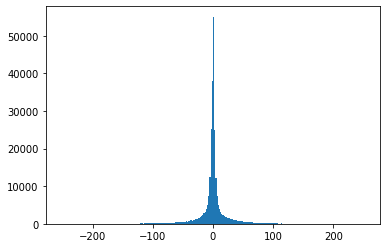

3


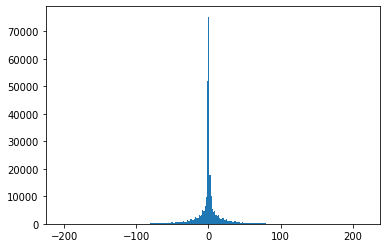

In [ ]:
titles = ['cA', 'cH', 'cV', 'cD']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA, cH, cV, cD]):
  print(i)
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
  gray_hist = plt.hist(a.ravel(), bins = 256)
  #plt.xlabel('Intensity $n$')
  #plt.ylabel('Number $h(n)$')
  plt.show()
fig.tight_layout()
plt.show()


It is worth paying attention to the size of each set: it is a quarter of the original image size.
We see that the last 3 sets are close to zero (gray). This ability of the wavelet transform to sparsely represent natural images is a key to image compression and restoration.
Let's make one more Haar wavelet transform, but this time for the first set:


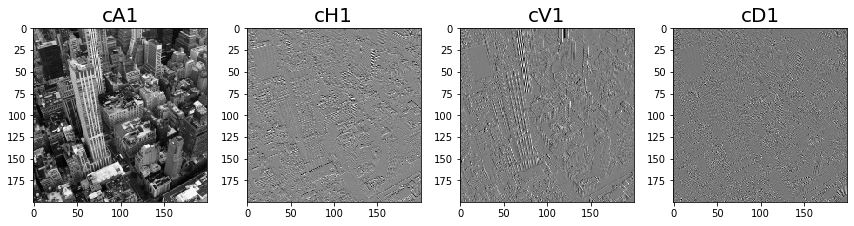

In [ ]:
cA1, (cH1, cV1, cD1) = pywt.dwt2(cA,wavelet)
titles = ['cA1', 'cH1', 'cV1', 'cD1']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA1, cH1, cV1, cD1]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
fig.tight_layout()
plt.show()


If we continue further (transform can be done recursively), then 

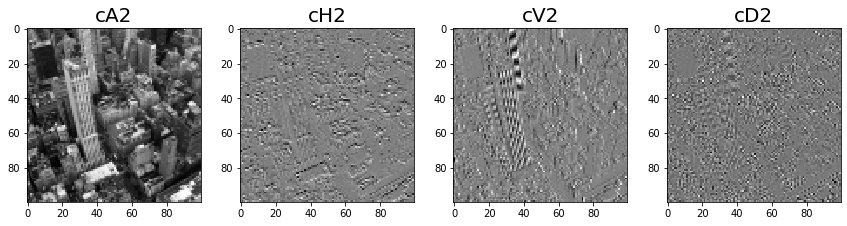

In [ ]:
cA2, (cH2, cV2, cD2) = pywt.dwt2(cA1,wavelet)
titles = ['cA2', 'cH2', 'cV2', 'cD2']
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([cA2, cH2, cV2, cD2]):
  ax = fig.add_subplot(1, 4, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=20)
fig.tight_layout()
plt.show()

The quality of the first set starts to deteriorate. Let's try to take the original image and apply the resize function to it to compare with the cA2 set. 


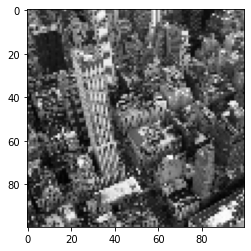

In [ ]:
image_resized = cv2.resize(image, cA2.shape)  # resize to the cA2 set size 
plt.imshow(image_resized,cmap='gray');
plt.show()

The difference is visible: cA2 set gives the better image.
Now let's try to restore the original image. Let's make the inverse Haar wavelet transform using the idwt2 function and the first sets C that we have obtained (the similar could be done for all other sets).

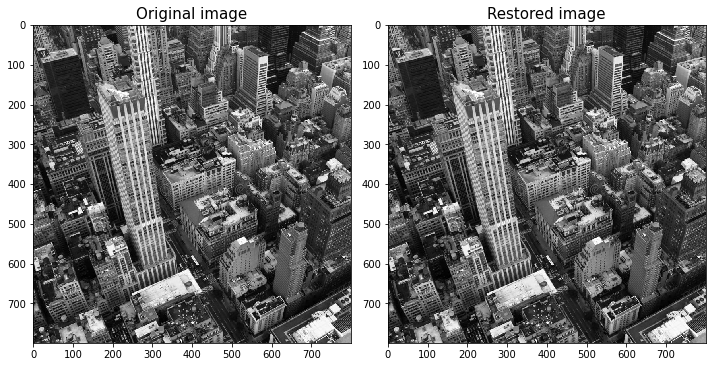

In [ ]:
w, h = image.shape  # the size of the original image
c_inverse = pywt.idwt2((c),wavelet)[:h,:w]
titles = ['Original image', 'Restored image']
fig = plt.figure(figsize=(10, 6))
for i, a in enumerate([image,c_inverse]):
  ax = fig.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles[i], fontsize=15)
fig.tight_layout()
plt.show()


We can't see the difference with the naked eye. But the benefits of the transformation are still unclear.

Now we will try to “remove all the unnecessary”: we will set to zero all the coefficients that are close to unity in the sets, i.e. we will make the quantization. Indeed, let's build the charts of the first row for all elements of the set (cA, cH, cV, cD)

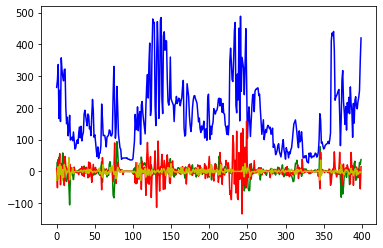

In [ ]:
x = [i for i in range(len(c[0]))]   # X coordinate for сА
y = [c[0][0][i] for i in range(len(c[0]))]  # Y coordinate for сА (the 0 row)
x1 = [i for i in range(len(c[1][0]))]   # X coordinate for сH
y1 = [c[1][0][0][i] for i in range(len(c[1][0]))] #  Y coordinate for сH (the 0 row)
x2 = [i for i in range(len(c[1][1]))]  # X coordinate for сV
y2 = [c[1][1][0][i] for i in range(len(c[1][1]))]  # Y coordinate for сV (the 0 row)
x3 = [i for i in range(len(c[1][2]))]  # координата Х для сD
y3 = [c[1][2][0][i] for i in range(len(c[1][2]))]  # Y coordinate for сD(the 0 row) 
plt.plot(x,y,'b',x1,y1,'g',x2,y2,'r',x3,y3,'y') # cA - blue, сH -green, сV - red сD - yellow


Obviously, the number of “small” coefficients in the sets cH, cV, cD is large and their zeroing will not be critical.

The number of zeros in a set can be obtained as follows:


In [ ]:
print('The number of zeros in the set cA =',sum(sum(c[0][m] == 0) for m in range(len(c[0]))))
print('The number of zeros in the set cH =',sum(sum(c[1][0][m] == 0) for m in range(len(c[1][0]))))
print('The number of zeros in the set cV =',sum(sum(c[1][1][m] == 0) for m in range(len(c[1][1]))))
print('The number of zeros in the set cD =',sum(sum(c[1][2][m] == 0) for m in range(len(c[1][2]))))


The number of zeros in the set cA = 0
The number of zeros in the set cH = 3104
The number of zeros in the set cV = 4048
The number of zeros in the set cD = 6564


The total number of zeros in all sets is to be calculated as follows:

In [ ]:
print((sum(sum(sum(c[1][m][n] == 0) for n in range(len(c[1][0]))) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(len(c[0]))))

13716


First, let's take some value (a threshold) and set all coefficient with absolute value less than the threshold to zero. Let's display the number of zeros after all changes.

First, for the threshold equal to 10

In [ ]:
threshold = 10
h1 = cA.shape[0] # all the sets have the form of a square matrix
for i in range(h1):
      c[0][i][np.abs(c[0][i])<threshold] = 0.0 # for cA
      for j in range(len(c[1])):
         c[1][j][i][np.abs(c[1][j][i])<threshold] = 0.0  # for cH,cV,cD
print('The number of zeros =',(sum(sum(sum(c[1][m][n] == 0) for n in range(h1)) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(h1)))


The number of zeros = 306542


Thus, we zeroed 306542 – 13716 = 292826 coefficients. Repeating these manipulations, you can see that for the second Haar wavelet transform, the number of zeros will increase, etc.

Let's perform the inverse transformation (with new coefficients) and compare it with the original image (see the code above)

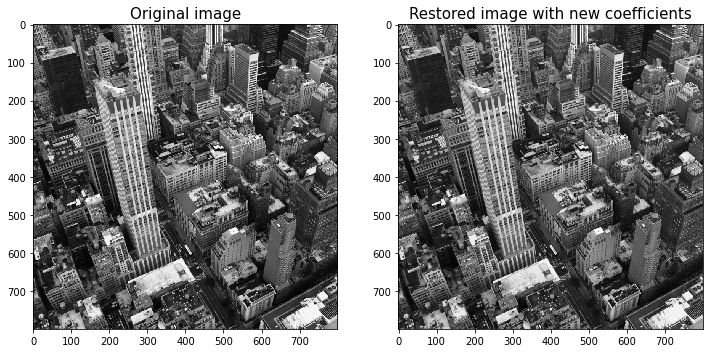

In [ ]:
c_inverse1 = pywt.idwt2((c),wavelet)[:h,:w]  # the coefficients are zeroed in the previous raw
titles1 = ['Original image', 'Restored image with new coefficients']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([image,c_inverse1]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

Let's try with a threshold = 100:

The number of zeros = 525452


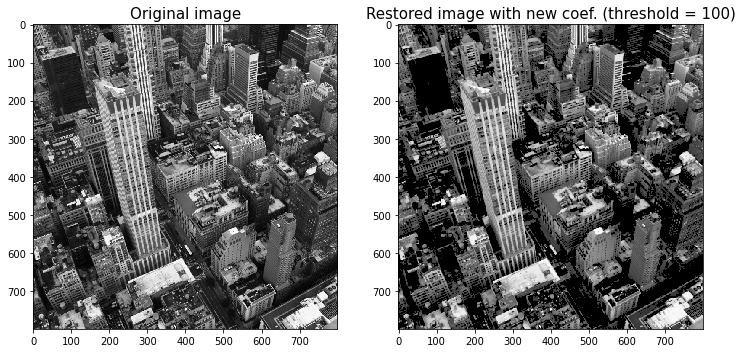

In [ ]:
threshold = 100
h1 = cA.shape[0] # all the sets have the form of a square matrix
for i in range(h1):
      c[0][i][np.abs(c[0][i])<threshold] = 0.0 # for cA
      for j in range(len(c[1])):
         c[1][j][i][np.abs(c[1][j][i])<threshold] = 0.0  # for cH,cV,cD
print('The number of zeros =',(sum(sum(sum(c[1][m][n] == 0) for n in range(h1)) for m in range(len(c[1])))) + sum(sum(c[0][m] == 0) for m in range(h1)))
c_inverse1 = pywt.idwt2((c),wavelet)[:h,:w]  # the coefficients are zeroed in the previous raw
titles1 = ['Original image', 'Restored image with new coef. (threshold = 100)']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([image,c_inverse1]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

It can be seen that the dark gray areas have become almost black. Other differences are practically invisible to the naked eye.

Let's compare the average pixel value in both images:


In [ ]:
print('The average pixel value for the original =',image.mean())
print('The average pixel value for the restored =',c_inverse1.mean())

The average pixel value for the original = 89.3980640625
The average pixel value for the restored = 80.33412343750001


And now let's display the differences in an image form using ImageChops.difference function. But first we must save the restored image:

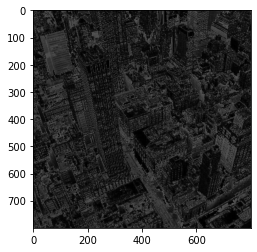

In [ ]:
cv2.imwrite('test_'+wavelet+'.jpg',c_inverse1)
image2 = cv2.imread('test_'+wavelet+'.jpg')  # Read the image
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)  # Transform to the grayscale 
img1=Image.open('new_york.jpg') # open the original
img2=Image.open('test_'+wavelet+'.jpg') # open the restored
result = ImageChops.difference(img1, img2)
result.show()
plt.imshow(result,cmap='gray');



We have used the Haar wavelet transform and the most primitive quantization method.
You can see how much better (if at all better) will be the results, if you use a wavelet Daubechies transform (wavelet DВ4).

In the DB4 wavelet transform, the quadratic component is also filtered (in addition to the linear one, as in the Haar wavelet). For the wavelet transform DB4, make the same actions with the only exception: in the functions dwt2 and idwt2, instead of 'haar', we must write 'db4' (Daubechies). In our case, we assign the value 'db4' to the wavelet. We take the same original image, apply the DQ4 wavelet transform to it, obtain the sets, count the number of zeros in them, set to zero those coefficients that are less than threshold = 100, count the number of zeros, make the inverse wavelet transform DQ4 on the new (set to zero) sets, compare the result obtained with that for the Haar wavelet transform



The amount of sets before quantizayion (DB4) = 0
The number of zeros after quantization (DB4) = 535473


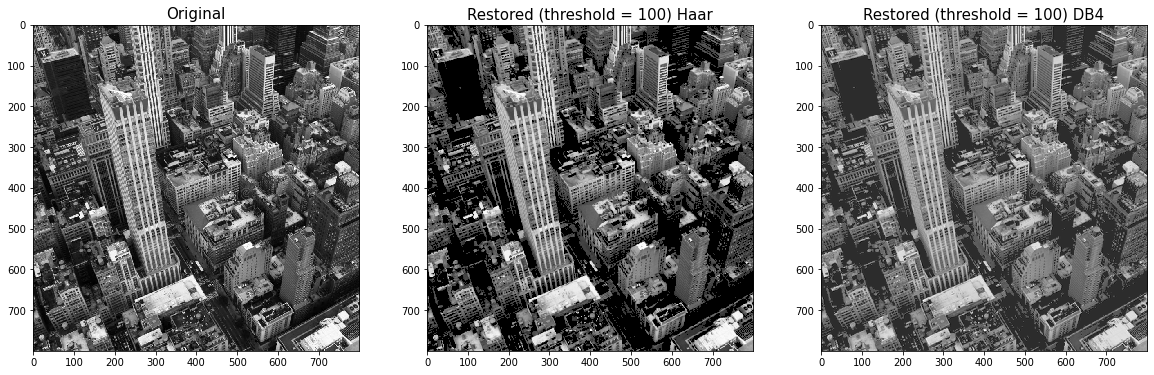

In [ ]:
wavelet = 'db4'
c_new = pywt.dwt2(image,wavelet)
cA_new, (cH_new, cV_new, cD_new)= c_new
print('The amount of sets before quantizayion (DB4) =',(sum(sum(sum(c_new[1][m][n] == 0) for n in range(h1)) for m in range(len(c_new[1])))) + sum(sum(c_new[0][m] == 0) for m in range(h1)))
threshold = 100
h1 = cA_new.shape[0] # all the sets have the form of a square matrix
for i in range(h1):
      c_new[0][i][np.abs(c_new[0][i])<threshold] = 0.0 # для cA
      for j in range(len(c_new[1])):
         c_new[1][j][i][np.abs(c_new[1][j][i])<threshold] = 0.0  # для cH,cV,cD
print('The number of zeros after quantization (DB4) =',(sum(sum(sum(c_new[1][m][n] == 0) for n in range(h1)) for m in range(len(c_new[1])))) + sum(sum(c_new[0][m] == 0) for m in range(h1)))
c_inverse_new = pywt.idwt2((c_new),wavelet)[:h,:w]  # the coef. are set to zero in the last raw
titles1 = ['Original', 'Restored (threshold = 100) Haar', 'Restored (threshold = 100) DB4']
fig1 = plt.figure(figsize=(20, 6))
for i, a in enumerate([image,c_inverse1,c_inverse_new]):
  ax = fig1.add_subplot(1, 3, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()

Let's find the differences from the original one:

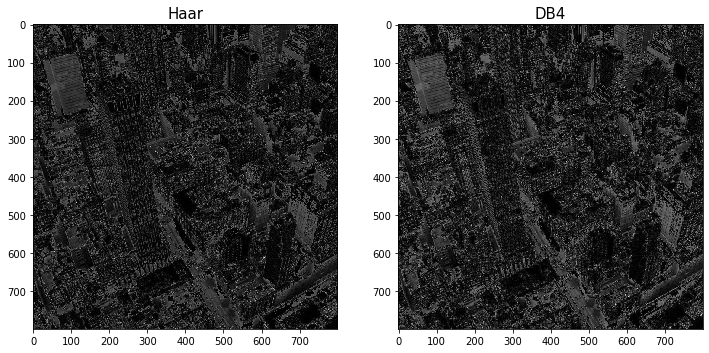

In [ ]:
cv2.imwrite('test_'+wavelet+'.jpg',c_inverse_new)
image2 = cv2.imread('test_'+wavelet+'.jpg')  # Read the image
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)  # Transform it to the grayscale 
img1=Image.open('new_york.jpg') # open the original
img2=Image.open('test_'+wavelet+'.jpg') # open the restored
result_new = ImageChops.difference(img1, img2)
titles1 = ['Haar', 'DB4']
fig1 = plt.figure(figsize=(12, 6))
for i, a in enumerate([result, result_new]):
  ax = fig1.add_subplot(1, 2, i + 1)
  ax.imshow(a, interpolation="nearest", cmap = 'gray')
  ax.set_title(titles1[i], fontsize=15)
fig.tight_layout()
plt.show()


As a result, we can summarize:

The wavelet transform works better than the standard RESIZE;

The number of zeros allows you to better compress files in the future.
Indeed, each integer value takes 1 byte, the real value takes 8 bytes, the image size is 800X800. The size of the original image (for integers) is about 0.6 megabytes, while standard archivers (for example,ZIP) can compress it by 5%. If you take the restored image, roughly convert it to integer values, and archive it, the file size will be reduced by almost 70%!

Of course, we have only considered the "tip of the iceberg", using the most primitive method of quantization, rough file conversion, etc., etc. But you always need to start somewhere! Good luck :)